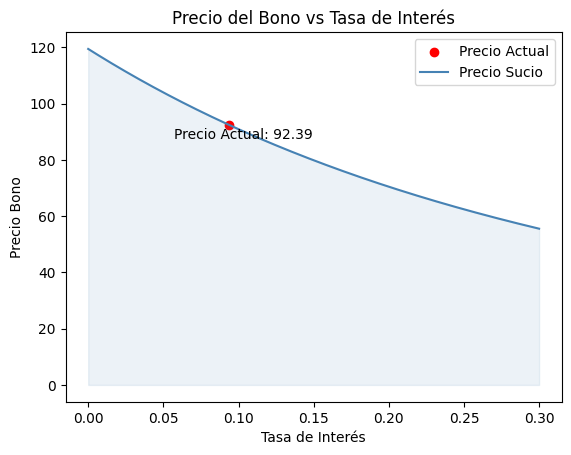

M_BONOS_270304


,Días Flujo,Flujo,Valor Presente Bruto,Interés Devengado,Valor Presente Neto
0,13.0,2.780556,2.771350,2.581944,0.189405
1,195.0,2.780556,2.645624,0.000000,2.645624
2,377.0,2.780556,2.525602,0.000000,2.525602
3,559.0,2.780556,2.411024,0.000000,2.411024
4,741.0,2.780556,2.301645,0.000000,2.301645
5,923.0,2.780556,2.197228,0.000000,2.197228
6,1105.0,102.780556,77.533834,0.000000,77.533834
Total,1105.0,119.463889,92.386307,2.581944,89.804362


,Dato
Concepto,
Precio Sucio,92.386307
Interés Devengado,2.581944
Precio Limpio,89.804362
Duración Macaulay,2.773989
Duración Modificada,2.648143
Convexidad,8.814782


In [1]:
# Importamos Librerías
from abc import abstractmethod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class Bono:
    def __init__(
        self,
        valor_nominal,
        tasa_cupon,
        tasa_rendimiento,
        sobre_tasa,
        periodo_cupon,
        dias_vencimiento,
        dias_por_año,
    ):
        self.valor_nominal = valor_nominal  # Valor nominal
        self.tasa_cupon = tasa_cupon  # Tasa del cupón
        self.tasa_rendimiento = tasa_rendimiento  # Tasa de interés
        self.sobre_tasa = sobre_tasa  # Sobretasa
        self.periodo_cupon = periodo_cupon  # Frecuencia o periodo de cada cupón
        self.dias_vencimiento = dias_vencimiento  # Días hasta el vencimiento
        self.dias_por_año = dias_por_año  # Días por año (360, 365, etc.)
        self.flujos = None  # Se definirá en subclases

    def obtener_cupones(self):
        # Calcular el número total de cupones (puede incluir decimales)
        total_cupones = self.dias_vencimiento / self.periodo_cupon
        cupones_completos = int(total_cupones)
        es_fraccionado = total_cupones > cupones_completos
        fraccion_cupon = total_cupones - cupones_completos if es_fraccionado else 0

        return cupones_completos, es_fraccionado, fraccion_cupon

    def obtener_intereses_devengados(self):
        cupones_completos, es_fraccionado, fraccion_cupon = self.obtener_cupones()
        longitud = cupones_completos + 1 if es_fraccionado else cupones_completos
        intereses_devengados = np.zeros(longitud)
        if es_fraccionado:
            intereses_devengados[0] = (
                (1 - fraccion_cupon)
                * (self.periodo_cupon)
                * self.valor_nominal
                * self.tasa_cupon
                / self.dias_por_año
            )

        return intereses_devengados

    def obtener_factores(self):
        cupones_completos, es_fraccionado, fraccion_cupon = self.obtener_cupones()
        longitud = cupones_completos + (1 if es_fraccionado else 0)
        factores = np.zeros(longitud)

        if es_fraccionado:
            factores = np.arange(start=fraccion_cupon, stop=fraccion_cupon + longitud)
        else:
            factores = np.arange(start=1, stop=longitud + 1)

        return factores

    def obtener_valores_presentes(self, tasa_rendimiento=None):
        if tasa_rendimiento is None:
            tasa_rendimiento = self.tasa_rendimiento
        if self.flujos is None:
            self.definir_flujos()  # Asegura que self.flujos esté definido
        factores = self.obtener_factores()
        descuento = (
            1
            + (tasa_rendimiento + self.sobre_tasa)
            * self.periodo_cupon
            / self.dias_por_año
        ) ** -factores
        valores_presentes = self.flujos * descuento

        return valores_presentes

    def obtener_calendario_pagos(self):
        factores = self.obtener_factores()
        dias_flujo = factores * self.periodo_cupon
        flujo_efectivo = self.definir_flujos()
        valor_presente_bruto = self.obtener_valores_presentes()
        interes_devengado = self.obtener_intereses_devengados()
        valor_presente_neto = valor_presente_bruto - interes_devengado

        df = {
            "Días Flujo": dias_flujo,
            "Flujo": flujo_efectivo,
            "Valor Presente Bruto": valor_presente_bruto,
            "Interés Devengado": interes_devengado,
            "Valor Presente Neto": valor_presente_neto,
        }

        # Convertimos al formato DataFrame con pandas

        calendario_pagos = pd.DataFrame(df)
        calendario_pagos.loc["Total"] = [
            dias_flujo[-1],
            flujo_efectivo.sum(),
            valor_presente_bruto.sum(),
            interes_devengado.sum(),
            valor_presente_neto.sum(),
        ]
        return calendario_pagos

    def obtener_medidas(self):
        precio_sucio = self.calcular_precio_sucio()
        interes_devengado = self.interes_devengado
        precio_limpio = self.precio_limpio
        duracion_macaulay = self.duracion_macaulay
        duracion_modificada = self.duracion_modificada
        convexidad = self.calcular_convexidad(0.0001)

        datos = {
            "Concepto": [
                "Precio Sucio",
                "Interés Devengado",
                "Precio Limpio",
                "Duración Macaulay",
                "Duración Modificada",
                "Convexidad",
            ],
            "Dato": [
                precio_sucio,
                interes_devengado,
                precio_limpio,
                duracion_macaulay,
                duracion_modificada,
                convexidad,
            ],
        }

        medidas = pd.DataFrame(datos)
        medidas.set_index("Concepto", inplace=True)

        return medidas

    def obtener_grafico_precio_ytm(self, max, min, escenarios):
        tasa_interes_potencial = np.linspace(min, max, escenarios)
        precio_sucio = np.zeros(escenarios)
        precio = np.zeros(escenarios)
        precio_base = self.calcular_precio_sucio()

        for idx, i in enumerate(tasa_interes_potencial):
            precio_sucio[idx] = self.calcular_precio_sucio(tasa_rendimiento=i)

        plt.scatter(
            [self.tasa_rendimiento], [precio_base], color="red", label="Precio Actual"
        )  # Punto para el precio actual
        plt.plot(
            tasa_interes_potencial,
            precio_sucio,
            color="steelblue",
            label="Precio Sucio",
        )
        plt.fill_between(
            tasa_interes_potencial, precio_sucio, color="steelblue", alpha=0.10
        )  # Área azul semitransparente
        plt.annotate(
            f"Precio Actual: {precio_base:.2f}",
            (self.tasa_rendimiento, precio_base),
            textcoords="offset points",
            xytext=(10, -10),
            ha="center",
        )

        plt.xlabel("Tasa de Interés")
        plt.ylabel("Precio Bono")
        plt.title("Precio del Bono vs Tasa de Interés")

        plt.legend()
        plt.show()

    def calcular_precio_sucio(self, tasa_rendimiento=None):
        if tasa_rendimiento is None:
            tasa_rendimiento = self.tasa_rendimiento
        valor_presente_bruto = self.obtener_valores_presentes(
            tasa_rendimiento=tasa_rendimiento
        )
        precio_sucio = valor_presente_bruto.sum()

        return precio_sucio

    def calcular_convexidad(self, cambio):
        tasa_original = self.tasa_rendimiento
        precio_mas = self.calcular_precio_sucio(tasa_rendimiento=tasa_original + cambio)
        precio_menos = self.calcular_precio_sucio(
            tasa_rendimiento=tasa_original - cambio
        )
        precio_base = self.calcular_precio_sucio()
        convexidad = (precio_menos + precio_mas - (2 * precio_base)) / (
            (cambio**2) * precio_base
        )

        return convexidad

    @property
    def interes_devengado(self):
        intereses_devengados = self.obtener_intereses_devengados()
        interes_devengado = intereses_devengados.sum()

        return interes_devengado

    @property
    def precio_limpio(self):
        precio_sucio = self.calcular_precio_sucio()
        interes_devengado = self.interes_devengado
        precio_limpio = precio_sucio - interes_devengado

        return precio_limpio

    @property
    def duracion_macaulay(self):
        valor_presente_bruto = self.obtener_valores_presentes()
        factores = self.obtener_factores()
        proporcion = valor_presente_bruto / self.calcular_precio_sucio()
        tiempo_proporcion = proporcion * factores
        duracion_macaulay = (
            tiempo_proporcion.sum() * self.periodo_cupon / self.dias_por_año
        )

        return duracion_macaulay

    @property
    def duracion_modificada(self):
        duracion_macaulay = self.duracion_macaulay
        duración_modificada = duracion_macaulay / (
            1
            + (self.tasa_rendimiento + self.sobre_tasa)
            * self.periodo_cupon
            / self.dias_por_año
        )
        return duración_modificada

    @abstractmethod
    def definir_flujos(self):
        pass


class CuponCero(Bono):
    def definir_flujos(self):
        factores = self.obtener_factores()
        self.flujos = np.zeros(len(factores))
        self.flujos[-1] = (
            self.valor_nominal
        )  # Solo hay un flujo, el valor nominal al final

        return self.flujos


class CuponFijo(Bono):
    def definir_flujos(self):
        factores = self.obtener_factores()
        cupones = np.full(
            len(factores) - 1,
            self.valor_nominal
            * self.tasa_cupon
            * self.periodo_cupon
            / self.dias_por_año,
        )
        self.flujos = np.append(
            cupones, [self.valor_nominal + cupones[-1]]
        )  # Añadir el valor nominal al final

        return self.flujos


class CuponVariable(Bono):
    def definir_flujos(self):
        factores = self.obtener_factores()
        cupones = np.full(
            len(factores) - 1,
            self.valor_nominal
            * self.tasa_rendimiento
            * self.periodo_cupon
            / self.dias_por_año,
        )
        cupones[0] = (
            self.valor_nominal
            * self.tasa_cupon
            * self.periodo_cupon
            / self.dias_por_año
        )

        self.flujos = np.append(
            cupones, [self.valor_nominal + cupones[-1]]
        )  # Añadir el valor nominal al final

        return self.flujos


cete = CuponCero(10, 0, 0.1550, 0, 28, 28, 360)
bonovariable = CuponFijo(100, 0.07, 0.08, 0, 182, 1036, 360)
bono_cfa_1 = CuponFijo(100, 0.08, 0.1040, 0, 360, 10 * 360, 360)
bono_cfa_2 = CuponFijo(100, 0.06, 0.06, 0, 180, 16 * 180 - 57, 360)

# Reales
M_BONOS_270304 = CuponFijo(100, 0.055, 0.094, 0, 182, 1105, 360)
BI_CETES_240321 = CuponCero(10, 0, 0.1115, 0, 27, 27, 360)

medidas = M_BONOS_270304.obtener_medidas()
calendario = M_BONOS_270304.obtener_calendario_pagos()

# agrege este ejemplo
M_BONOS_270304.obtener_grafico_precio_ytm(0, 0.30, 500)

print("M_BONOS_270304")
display(calendario)
display(medidas)
# print(M_BONOS_270304.obtener_calendario_pagos())
# print(bonovariable.obtener_calendario_pagos())

In [22]:
factores_cete = cete.obtener_factores()
cupones_cete = cete.obtener_cupones()
display(factores_cete.size)
display(factores_cete)
display(cupones_cete)

1

array([1.])

(1, False, 0)

In [23]:
factores_bonovariable = bonovariable.obtener_factores()
cupones_bonovariable = bonovariable.obtener_cupones()
display(factores_bonovariable.size)
display(factores_bonovariable)
display(cupones_bonovariable)

6

array([0.69230769, 1.69230769, 2.69230769, 3.69230769, 4.69230769,
       5.69230769])

(5, True, 0.6923076923076925)

In [24]:
factores_bono_cfa_2 = bono_cfa_2.obtener_factores()
cupones_bono_cfa_2 = bono_cfa_2.obtener_cupones()
display(factores_bono_cfa_2.size)
display(factores_bono_cfa_2)
display(cupones_bono_cfa_2)

16

array([ 0.68333333,  1.68333333,  2.68333333,  3.68333333,  4.68333333,
        5.68333333,  6.68333333,  7.68333333,  8.68333333,  9.68333333,
       10.68333333, 11.68333333, 12.68333333, 13.68333333, 14.68333333,
       15.68333333])

(15, True, 0.6833333333333336)